#### Importing libraries

In [1]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk 
import warnings
warnings.filterwarnings("ignore")

try:
    from wordcloud import WordCloud
except:
    !pip install wordcloud
    from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

try: 
    from xgboost import XGBClassifier
except:
    !pip install xgboost
    from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### Lets load up the data and check how each DataFrame looks like

In [2]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)

In [3]:
CanElec = pd.read_csv('Canadian_elections_2019.csv' , sep=',' , header=None)
generic_tweet =pd.read_csv('generic_tweets.txt' , sep=',' , header=None)

In [4]:
CanElec.head(10)

0                                    1                                                  2
0  sentiment                      negative_reason                                               text
1   negative  Women Reproductive right and Racism  b"@RosieBarton So instead of your suggestion, ...
2   positive                                  NaN  b"#AllWomanSpacewalk it's real!\n@Space_Statio...
3   negative                              Economy  b"#Brantford It's going to cost YOU $94 BILLIO...
4   positive                                  NaN  b"#Canada #CanadaElection2019 #CanadaVotes \n#...
5   negative                              Economy  b"#Canada #taxpayers are sick &amp; tired of h...
6   negative                               Others  b"#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...
7   positive                                  NaN  b"#CDNmedia #elxn43 #cdnpoli #PPC Rocky Dong h...
8   positive                                  NaN  b"#cdnpoli #elxn43 The Liberals ++ more than d...
9   negative                               Others  b"#chooseforward #cdnpoli #elxn43\nCanada, Don...

In [5]:
generic_tweet.head(10)

0           1                             2         3                4                                                  5
0  class          id                          date     query             user                                               text
1      0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...
2      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton  is upset that he can't update his Facebook by ...
3      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus  @Kenichan I dived many times for the ball. Man...
4      0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF    my whole body feels itchy and like its on fire 
5      0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli  @nationwideclass no, it's not behaving at all....
6      0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY         joy_wolf                      @Kwesidei not the whole crew 
7      0  1467811592  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY          mybirch                                        Need a hug 
8      0  1467811594  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY             coZZ  @LOLTrish hey  long time no see! Yes.. Rains a...
9      0  1467811795  Mon Apr 06 22:20:05 PDT 2009  NO_QUERY  2Hood4Hollywood               @Tatiana_K nope they didn't have it

# Data Cleaning

#### Cleaning the tweets involves removing all URLs, HTMLS , extra lines, punctuations, and also stop words

In [6]:
#Removing HTMLs and new line characters
CanElec[2] = CanElec[2].str.replace('http\S+|www.\S+', '', case=False)
CanElec[2] = CanElec[2].str.replace('\n', '', case=False)
generic_tweet[5] = generic_tweet[5].str.replace('http\S+|www.\S+', '', case=False)
generic_tweet[5] = generic_tweet[5].str.replace('\n', '', case=False)

In [7]:
tweets1 = CanElec.iloc[:, 2].values
labels = CanElec.iloc[:, 0].values
tweets2 =generic_tweet.iloc[:, 5].values

In [8]:
processed_features1 = []
processed_features2 = []

In [9]:
for sentence in range(0, len(tweets1)):
    
    # Remove all the special characters
  
    processed_feature = re.sub(r'\W', ' ', str(tweets1[sentence]))
    processed_feature = re.sub(r'\bx\d*\b', '', processed_feature)
    processed_feature = re.sub(r'\bx\s+\b', '', processed_feature)
    processed_feature = re.sub(r'\bxe\d*\b', '', processed_feature)
    processed_feature = re.sub(r'\bxe\s+\b', '', processed_feature)
    processed_feature = re.sub(r'^xf\s+\b', '', processed_feature)
    processed_feature = re.sub(r'^xf\d*\b', '', processed_feature)
    processed_feature = re.sub(r'^xc\s+\b', '', processed_feature)
    processed_feature = re.sub(r'^xc\d*\b', '', processed_feature)
    processed_feature = re.sub(r'^xa\s+\b', '', processed_feature)
    processed_feature = re.sub(r'^xa\d*\b', '', processed_feature)
    processed_feature = re.sub(r'^x9\s+\b', '', processed_feature)
    processed_feature = re.sub(r'^x9\d*\b', '', processed_feature)
    processed_feature = re.sub(r'^x99\s+\b', '', processed_feature)
    processed_feature = re.sub(r'^x99\d*\b', '', processed_feature)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features1.append(processed_feature)

In [10]:
for sentence in range(0, len(tweets2)):
    
    # Remove all the special characters

    processed_feature2 = re.sub(r'\W', ' ', str(tweets2[sentence]))
    # remove all single characters
    processed_feature2= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature2)

    # Remove single characters from the start
    processed_feature2 = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature2) 

    # Substituting multiple spaces with single space
    processed_feature2 = re.sub(r'\s+', ' ', processed_feature2, flags=re.I)

    # Removing prefixed 'b'
    processed_feature2 = re.sub(r'^b\s+', '', processed_feature2)
    
    # Converting to Lowercase
    processed_feature2 = processed_feature2.lower() 

    
    processed_features2.append(processed_feature2)

#### Lets look at our tweet set after removing everything but the stop words

In [11]:
processed_features1[0:5]

['text',
 'rosiebarton so instead of your suggestion how about we agree that canadian women can not and should not trust that andrewscheer and conservatives government will protect woman right to have automony over her body let go with that cdnpoli elxn43 canada abortion ',
 'allwomanspacewalk it real space_station etobicokenorth cityofto onpoli cdnpoli elxn43 ',
 'brantford it going to cost you 94 billion for the next 4 years ask justin elxn43 cdnpoli canada ',
 'canada canadaelection2019 canadavotes elxn43 ncan decide this should help n']

In [12]:
processed_features2[0:5]

['text',
 ' switchfoot awww that a bummer you shoulda got david carr of third day to do it d',
 'is upset that he can update his facebook by texting it and might cry as result school today also blah ',
 ' kenichan dived many times for the ball managed to save 50 the rest go out of bounds',
 'my whole body feels itchy and like its on fire ']

In [13]:
CanElec.columns = CanElec.iloc[0]
generic_tweet.columns = generic_tweet.iloc[0]

In [14]:
CanElec['Clean_text'] = processed_features1
generic_tweet['Clean_text'] = processed_features2

In [15]:
CanElec.drop(CanElec.index[0], inplace = True)

In [16]:
generic_tweet.drop(generic_tweet.index[0], inplace = True)

#### Remove stopwords by using the NLTK library stopwords list and put then into a new column called nostop for each dataframe

In [17]:
stop = stopwords.words('english')

In [18]:
CanElec['nostop']= CanElec['Clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
generic_tweet['nostop']= generic_tweet['Clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [19]:
print(CanElec['nostop'][3])
print(generic_tweet['nostop'][3])

brantford going cost 94 billion next 4 years ask justin elxn43 cdnpoli canada
kenichan dived many times ball managed save 50 rest go bounds


#### Convert our sentiment categorical data into numercial values

In [20]:
generic_tweet['label']=generic_tweet['class'].apply(lambda x: 0 if x =='0' else 1)
CanElec['label']=CanElec['sentiment'].apply(lambda x: 0 if x =='negative' else 1)

#### Lets look at our both of our datasets after cleaning

In [21]:
generic_tweet.head()

0 class          id                          date     query             user                                               text                                         Clean_text                                             nostop  label
1     0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_  @switchfoot  - Awww, that's a bummer.  You sho...   switchfoot awww that a bummer you shoulda got...  switchfoot awww bummer shoulda got david carr ...      0
2     0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton  is upset that he can't update his Facebook by ...  is upset that he can update his facebook by te...  upset update facebook texting might cry result...      0
3     0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus  @Kenichan I dived many times for the ball. Man...   kenichan dived many times for the ball manage...  kenichan dived many times ball managed save 50...      0
4     0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF    my whole body feels itchy and like its on fire     my whole body feels itchy and like its on fire                    whole body feels itchy like fire      0
5     0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli  @nationwideclass no, it's not behaving at all....   nationwideclass no it not behaving at all m m...                   nationwideclass behaving mad see      0

In [22]:
CanElec.head()

0 sentiment                      negative_reason                                               text                                         Clean_text                                             nostop  label
1  negative  Women Reproductive right and Racism  b"@RosieBarton So instead of your suggestion, ...  rosiebarton so instead of your suggestion how ...  rosiebarton instead suggestion agree canadian ...      0
2  positive                                  NaN  b"#AllWomanSpacewalk it's real!\n@Space_Statio...  allwomanspacewalk it real space_station etobic...  allwomanspacewalk real space_station etobicoke...      1
3  negative                              Economy  b"#Brantford It's going to cost YOU $94 BILLIO...  brantford it going to cost you 94 billion for ...  brantford going cost 94 billion next 4 years a...      0
4  positive                                  NaN  b"#Canada #CanadaElection2019 #CanadaVotes \n#...  canada canadaelection2019 canadavotes elxn43 n...  canada canadaelection2019 canadavotes elxn43 n...      1
5  negative                              Economy  b"#Canada #taxpayers are sick &amp; tired of h...  canada taxpayers are sick amp tired of having ...  canada taxpayers sick amp tired hard earned do...      0

# Exploratory Analysis

#### We try to find which partys are mentioned in our elections dataset, to do this we need to consider what can be used to check for the party

#### The way I have done it is looking if the party or the party leader's name is located within the tweet and if located a true value is appended to the dataframe

In [23]:
CanElec["find_liberal"]= CanElec["text"].str.contains("(?i)liberal|justin|trudeau") 
CanElec["find_ndp"]= CanElec["text"].str.contains("(?i)ndp|jagmeet|singh") 
CanElec["find_cons"]= CanElec["text"].str.contains("(?i)conservative|andrew|scheer") 

#### We assign a party attribute 'Conservative', 'Liberal', 'NDP' or 'None' depending on if 1 party or no party is being talked about in the tweet

#### There may be a case that 2 or more parties are being talked about in the tweet, however more careful analysis would be required to see which party matchs the sentiment value of our dataset and as such we have made the party attribute for such situations = 'None'

In [24]:
CanElec["party_liberal"] = CanElec.apply(lambda x: x.find_liberal == True and x.find_liberal != x.find_ndp and x.find_liberal != x.find_cons, axis = 1)
CanElec["party_cons"] = CanElec.apply(lambda x: x.find_cons == True and x.find_cons != x.find_ndp and x.find_liberal != x.find_cons, axis = 1)
CanElec["party_ndp"] = CanElec.apply(lambda x: x.find_ndp == True and x.find_liberal != x.find_ndp and x.find_ndp != x.find_cons, axis = 1)

In [25]:
CanElec["Party"] = CanElec.apply(lambda x: 'Liberal' if x.party_liberal == True else ('Conservative' if x.party_cons == True else('NDP' if x.party_ndp == True else 'None')) , axis = 1)

In [26]:
list1 = list(range(6,12))
CanElec.drop(CanElec.columns[list1],axis = 1, inplace= True)
CanElec.drop(['Clean_text'],axis=1,inplace = True)

In [27]:
CanElec.head()

0 sentiment                      negative_reason                                               text                                             nostop  label         Party
1  negative  Women Reproductive right and Racism  b"@RosieBarton So instead of your suggestion, ...  rosiebarton instead suggestion agree canadian ...      0  Conservative
2  positive                                  NaN  b"#AllWomanSpacewalk it's real!\n@Space_Statio...  allwomanspacewalk real space_station etobicoke...      1          None
3  negative                              Economy  b"#Brantford It's going to cost YOU $94 BILLIO...  brantford going cost 94 billion next 4 years a...      0       Liberal
4  positive                                  NaN  b"#Canada #CanadaElection2019 #CanadaVotes \n#...  canada canadaelection2019 canadavotes elxn43 n...      1          None
5  negative                              Economy  b"#Canada #taxpayers are sick &amp; tired of h...  canada taxpayers sick amp tired hard earned do...      0       Liberal

#### Lets try visualizing some attributes of our dataset

#### Visualizing Canadian Election tweets

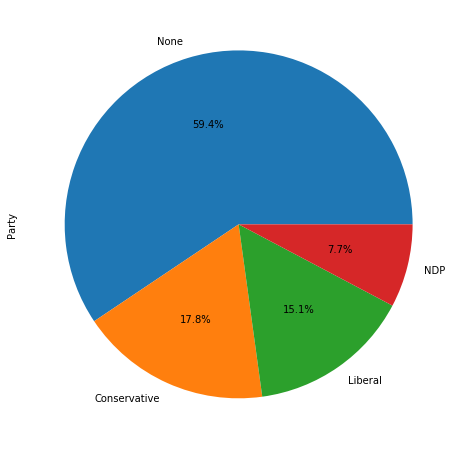

In [28]:
plt.figure(figsize=(10,8))
CanElec.Party.value_counts().plot(kind='pie',autopct='%.1f%%',ax = plt.gca())

#### The pie chart shows the percentage of users talking about a specific party, where we can see the conservatives and liberals taking the most attention from the users. The figure below shows the sentiment behind the tweet, with the conservatives having the most negative sentiment with the liberals following them with a 18% difference. We can see that most people are happy with the NDP for the current election year in their tweets

In [29]:
fig = plt.figure(figsize=(18,10), dpi=1600)
ax1 = plt.subplot2grid((1,3),(0,0))
CanElec[CanElec['Party'] == 'Conservative'].sentiment.value_counts().plot(kind='pie',autopct='%.1f%%',ax = plt.gca())
plt.title('Conservative sentiment')
ax1 = plt.subplot2grid((1,3),(0,1))
CanElec[CanElec['Party'] == 'NDP'].sentiment.value_counts().plot(kind='pie',autopct='%.1f%%',ax = plt.gca())
plt.title('NDP Sentiment')
ax1 = plt.subplot2grid((1,3),(0,2))
CanElec[CanElec['Party'] == 'Liberal'].sentiment.value_counts().plot(kind='pie',autopct='%.1f%%',ax = plt.gca())
plt.title('Liberal Sentiment')

Text(0.5, 1.0, 'Liberal Sentiment')

#### Visualizing Generic Tweets

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000263A0C5C710>]],
      dtype=object)

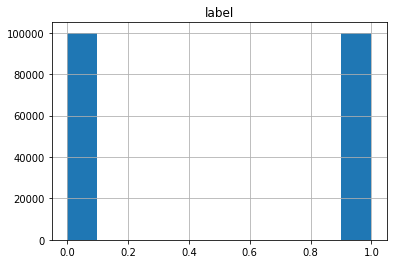

In [30]:
generic_tweet.hist('label')

#### The dataset is quite well balanced in regards to target variables with equal values for each variable

In [31]:
generic_tweet['length'] = generic_tweet['text'].apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000263A0C8E828>,
      dtype=object)

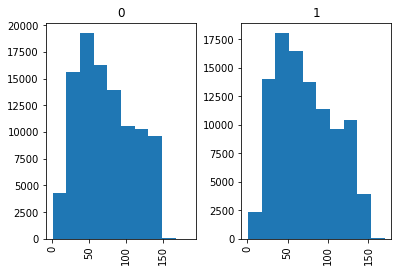

In [32]:
generic_tweet.hist('length',by='label')

#### Looking at the length of the tweet vs the sentiment value, we can see no proper trend so lets move onto word clouds and see if we can find something for differing sentiments

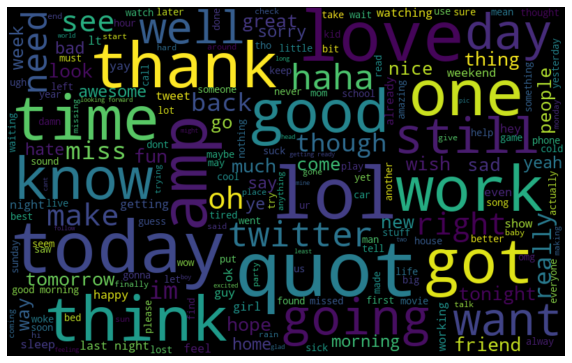

In [33]:
all_words = ' '.join([text for text in generic_tweet['nostop']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### For word clouds we have 3 categories, overall, positive sentiment and negative sentiment. These words will be considered when we start vectorizing our text data in our algorithm. As we can see there are a lot of differing words between positive and negative sentiments such as miss,sad for negative whereas  love, thank are mentioned various times in the positive sentiments

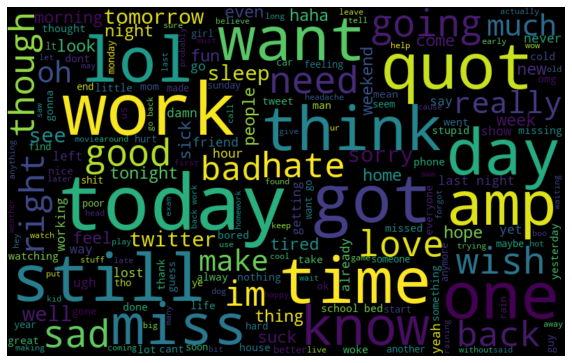

In [34]:
Negative_words = ' '.join([text for text in generic_tweet['nostop'][generic_tweet['label'] == 0]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(Negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

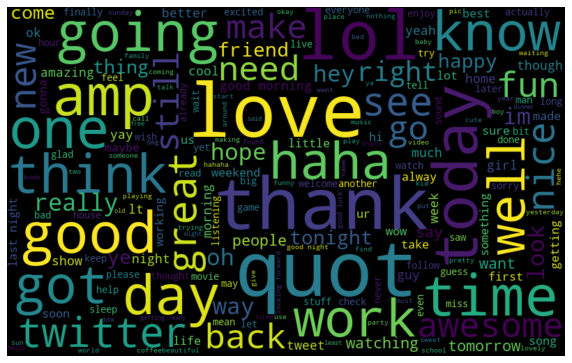

In [35]:
Positive_words = ' '.join([text for text in generic_tweet['nostop'][generic_tweet['label'] == 1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(Positive_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Model Preparations

#### We will be implementing both TF-IDF and Bag of Words approach for our models and check the accuracy metric for each and choose the highest 1 for the test set

#### Implementing the TF-IDF vector and selecting a max feature size of 12000 words of the top features by document frequency, ignoring words with a minimum frequency of 6 and maximum frequency above 80%, we will implement the same parameters on our bag of words vector aswell

#### We have chosen to limit the number of features as the total number of feature vectors of 130,000 is made if no parameters are defined

In [36]:
vectorizer = TfidfVectorizer (max_features = 12000, min_df=6, max_df=0.8)
processed_features1 = vectorizer.fit_transform(generic_tweet['nostop'])
processed_features2 = vectorizer.transform(CanElec['nostop'])

In [37]:
X = processed_features1
y = generic_tweet['label']

In [38]:
X.shape

(200000, 12000)

In [39]:
tfid_test = processed_features2
final_y = CanElec['label']

In [40]:
vectorizer1 = CountVectorizer(max_features = 12000, min_df=6, max_df=0.8)
processed_features1 = vectorizer1.fit_transform(generic_tweet['nostop'])
processed_features2 = vectorizer1.transform(CanElec['nostop'])

In [41]:
Z = processed_features1
bow_test = processed_features2

In [42]:
Z.shape

(200000, 12000)

#### Split each text vectorized feature into a 70% 30% train-test set and compute on different models

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.3, random_state=42)

#### We will implement 7 different algorithms for classification and compare the accuracy metric for each one. The one that has the highest will be then chosen for our test set

#### Also due to how long it takes to train each algorithm, I have commented out a majority of them and printed the results I would have gotten if I ran them

In [44]:
rndmf = RandomForestClassifier(n_estimators = 10)
rndmf.fit(X_train, y_train)
predtraintfidf = rndmf.predict(X_test)

In [45]:
rndmf = RandomForestClassifier(n_estimators = 10)
rndmf.fit(Z_train, y_train)
predtrainbow = rndmf.predict(Z_test)

In [46]:
print('The accuracy using TF-IDF with Random Forest Classification is:', accuracy_score(y_test, predtraintfidf)*100)
print('The accuracy using Bag Of Words with Random Forest Classification is:', accuracy_score(y_test, predtrainbow)*100)

The accuracy using TF-IDF with Random Forest Classification is: 73.3
The accuracy using Bag Of Words with Random Forest Classification is: 72.60833333333333


In [47]:
lgtreg = LogisticRegression()
lgtreg.fit(X_train, y_train)
predtraintfidf = lgtreg.predict(X_test)

In [48]:
lgtreg = LogisticRegression()
lgtreg.fit(Z_train, y_train)
predtrainbow = lgtreg.predict(Z_test)

In [49]:
print('The accuracy using TF-IDF with Logistic Regression is:', accuracy_score(y_test, predtraintfidf)*100)
print('The accuracy using Bag Of Words with Logistic Regression is:', accuracy_score(y_test, predtrainbow)*100)

The accuracy using TF-IDF with Logistic Regression is: 76.65833333333333
The accuracy using Bag Of Words with Logistic Regression is: 76.38333333333334


In [50]:
# KNN =KNeighborsClassifier()
# KNN.fit(X_train, y_train)
# predtraintfidf = KNN.predict(X_test)

In [51]:
# KNN =KNeighborsClassifier()
# KNN.fit(Z_train, y_train)
# predtrainbow = KNN.predict(Z_test)

In [52]:
# print('The accuracy using TF-IDF with K-Nearest Neighbours is:', accuracy_score(y_test, predtraintfidf)*100)
# print('The accuracy using Bag Of Words with K-Nearest Neighbours is:', accuracy_score(y_test, predtrainbow)*100)
print('The accuracy using TF-IDF with K-Nearest Neighbours is: 60.92166666666666')
print('The accuracy using Bag Of Words with K-Nearest Neighbours is: 67.16666666666666')

The accuracy using TF-IDF with K-Nearest Neighbours is: 60.92166666666666
The accuracy using Bag Of Words with K-Nearest Neighbours is: 67.16666666666666


In [53]:
# sup = svm.SVC(kernel='linear')
# sup.fit(X_train, y_train)
# predtraintfidf = sup.predict(X_test)

In [54]:
# sup = svm.SVC(kernel='linear')
# sup.fit(Z_train, y_train)
# predtrainbow = sup.predict(Z_test)

In [55]:
#print('The accuracy using TF-IDF with SVM is:', accuracy_score(y_test, predtraintfidf)*100)
#print('The accuracy using Bag Of Words with SVM is:', accuracy_score(y_test, predtrainbow)*100)
print('The accuracy using TF-IDF with SVM is: 76.45333333333333')
print('The accuracy using Bag Of Words with SVM is: 75.90333333333334')

The accuracy using TF-IDF with SVM is: 76.45333333333333
The accuracy using Bag Of Words with SVM is: 75.90333333333334


In [56]:
# dectree = DecisionTreeClassifier()
# dectree.fit(X_train, y_train)
# predtraintfidf = dectree.predict(X_test)

In [57]:
# dectree = DecisionTreeClassifier()
# dectree.fit(Z_train, y_train)
# predtrainbow = dectree.predict(Z_test)

In [58]:
# print('The accuracy using TF-IDF with Decision Tree Classifier is:', accuracy_score(y_test, predtraintfidf)*100)
# print('The accuracy using Bag Of Words with Decision Tree Classifier is:', accuracy_score(y_test, predtrainbow)*100)
print('The accuracy using TF-IDF with Decision Tree Classifier is: 69.425')
print('The accuracy using Bag Of Words with Decision Tree Classifier is: 69.04166666666667')

The accuracy using TF-IDF with Decision Tree Classifier is: 69.425
The accuracy using Bag Of Words with Decision Tree Classifier is: 69.04166666666667


In [59]:
# XGB = XGBClassifier()
# XGB.fit(X_train, y_train)
# predtraintfidf = XGB.predict(X_test)

In [60]:
# XGB = XGBClassifier()
# XGB.fit(Z_train, y_train)
# predtraintfiCanElec = XGB.predict(Z_test)

In [61]:
# print('The accuracy using TF-IDF with XGBoost Classifier is:', accuracy_score(y_test, predtraintfidf)*100)
# print('The accuracy using Bag Of Words with XGBoost Classifier is:', accuracy_score(y_test, predtrainbow)*100)
print('The accuracy using TF-IDF with XGBoost Classifier is: 66.855')
print('The accuracy using Bag Of Words with XGBoost Classifier is: 69.04166666666667')

The accuracy using TF-IDF with XGBoost Classifier is: 66.855
The accuracy using Bag Of Words with XGBoost Classifier is: 69.04166666666667


In [62]:
# MNB = MultinomialNB()
# MNB.fit(X_train, y_train)
# predtraintfidf = MNB.predict(X_test)

In [63]:
# MNB = MultinomialNB()
# MNB.fit(Z_train, y_train)
# predtrainbow = MNB.predict(Z_test)

In [64]:
# print('The accuracy using TF-IDF with MultiNomial Naive Bayes is:', accuracy_score(y_test, predtraintfidf)*100)
# print('The accuracy using Bag Of Words with MultiNomial Naive Bayes is:', accuracy_score(y_test, predtrainbow)*100)
print('The accuracy using TF-IDF with MultiNomial Naive Bayes is: 75.27166666666668')
print('The accuracy using Bag Of Words with MultiNomial Naive Bayes is: 75.665')

The accuracy using TF-IDF with MultiNomial Naive Bayes is: 75.27166666666668
The accuracy using Bag Of Words with MultiNomial Naive Bayes is: 75.665


#### As we can see from the results, the highest accuracy value we get is from the logistic regression algorithm with the TF-IDF vectorizer method used for the text data. Next we will implement this on our test set.

In [65]:
lgtreg = LogisticRegression()
lgtreg.fit(X_train, y_train)
final_predict = lgtreg.predict(tfid_test)

In [66]:
print(classification_report(final_y, final_predict))
print('The accuracy using TF-ICanElec with Logistic Regression is:', accuracy_score(final_y, final_predict)*100)

              precision    recall  f1-score   support

           0       0.60      0.45      0.52      1006
           1       0.60      0.73      0.66      1127

    accuracy                           0.60      2133
   macro avg       0.60      0.59      0.59      2133
weighted avg       0.60      0.60      0.59      2133

The accuracy using TF-ICanElec with Logistic Regression is: 60.19690576652602


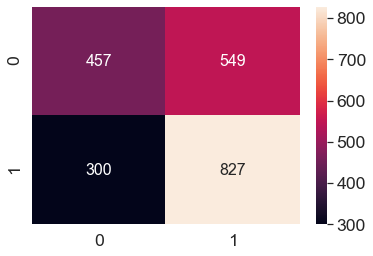

In [67]:
sn.set(font_scale=1.6)
sn.heatmap(confusion_matrix(final_y, final_predict), annot=True,annot_kws={"size": 16}, fmt='g')# font size
plt.show()

In [68]:
df = pd.DataFrame()

In [69]:
df['Actual Sentiment'] = CanElec['label']
df['Predicted Sentiment'] = final_predict
df['Party'] = CanElec['Party']
df['PSent'] = df['Predicted Sentiment'].apply(lambda x: 'Positive' if x == 1 else 'Negative')

In [70]:
df.head()

Actual Sentiment  Predicted Sentiment         Party     PSent
1                 0                    1  Conservative  Positive
2                 1                    1          None  Positive
3                 0                    0       Liberal  Negative
4                 1                    0          None  Negative
5                 0                    0       Liberal  Negative

#### Lets try to illustrate our results found below using piecharts and bar charts

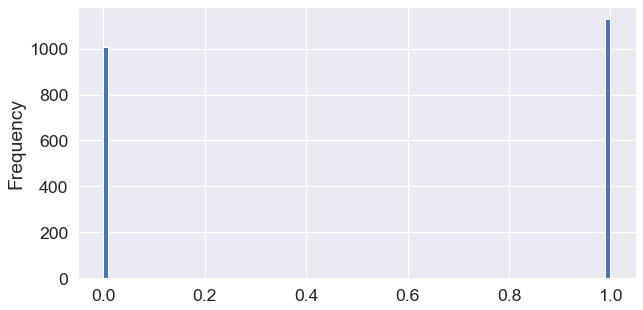

In [71]:
df['Actual Sentiment'].plot.hist(bins=100, figsize = (10,5))

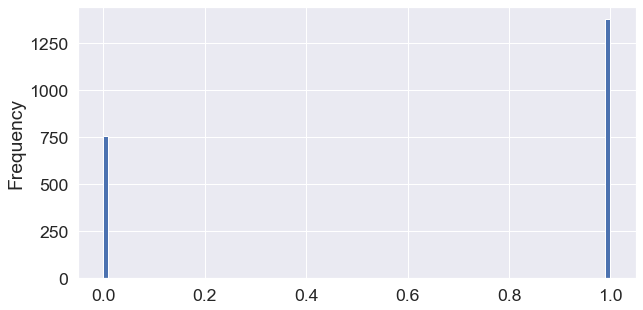

In [72]:
df['Predicted Sentiment'].plot.hist(bins=100, figsize = (10,5))

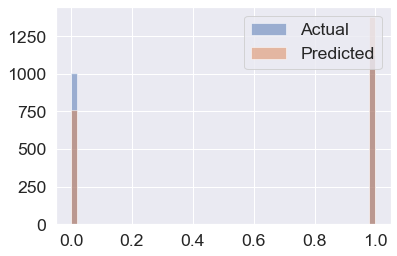

In [73]:
plt.hist(df['Actual Sentiment'], bins=50, alpha=0.5, label='Actual')
plt.hist(df['Predicted Sentiment'], bins=50, alpha=0.5, label='Predicted')
plt.legend(loc='upper right')
plt.show()

#### From the above histogram, we can see there is a higher predicted amount for the positive sentiment rather than the negative sentiment, which falls from a close to 1000 to 750. This shows that the opinion on twitter might not be a reliable method to predict the actual election results.

#### Lets see how each party performs by comparing their actual sentiments to their predicted sentiments

In [74]:
fig = plt.figure(figsize=(18,10), dpi=1600)
ax1 = plt.subplot2grid((2,3),(0,0))
CanElec[CanElec['Party'] == 'Conservative'].sentiment.value_counts().plot(kind='pie',autopct='%.1f%%',ax = plt.gca())
plt.title('Conservative sentiment')
ax1 = plt.subplot2grid((2,3),(0,1))
CanElec[CanElec['Party'] == 'NDP'].sentiment.value_counts().plot(kind='pie',autopct='%.1f%%',ax = plt.gca())
plt.title('NDP Sentiment')
ax1 = plt.subplot2grid((2,3),(0,2))
CanElec[CanElec['Party'] == 'Liberal'].sentiment.value_counts().plot(kind='pie',autopct='%.1f%%',ax = plt.gca())
plt.title('Liberal Sentiment')

ax1 = plt.subplot2grid((2,3),(1,0))
df[df['Party'] == 'Conservative'].PSent.value_counts().plot(kind='pie',autopct='%.1f%%',ax = plt.gca())
plt.title('Conservative Predicted sentiment')
ax1 = plt.subplot2grid((2,3),(1,1))
df[df['Party'] == 'NDP'].PSent.value_counts().plot(kind='pie',autopct='%.1f%%',ax = plt.gca())
plt.title('NDP Predicted Sentiment')
ax1 = plt.subplot2grid((2,3),(1,2))
df[df['Party'] == 'Liberal'].PSent.value_counts().plot(kind='pie',autopct='%.1f%%',ax = plt.gca())
plt.title('Liberal Predicted Sentiment')

Text(0.5, 1.0, 'Liberal Predicted Sentiment')

#### The conservatives have a very significant error when looking at their sentiment difference between actual and predicted of around 30%. NDP values for predicted sentiment and actual sentiment is quite close but even the liberal sentiments have an error of about 18% which cannot be neglected.

#### An accuracy of 60% from our test set shows that it is not a very reliable method to do sentiment analysis using twitter data to predict election outcomes.

#### Lets now try making a sentiment analysis on the reasoning behind negative sentiments as our target variable and each tweet is taken as the feature set

In [75]:
dfc = CanElec[CanElec['sentiment'] == 'negative']

In [76]:
dfc.drop(['label'],axis=1,inplace=True)

In [77]:
dfc.head()

0 sentiment                      negative_reason                                               text                                             nostop         Party
1  negative  Women Reproductive right and Racism  b"@RosieBarton So instead of your suggestion, ...  rosiebarton instead suggestion agree canadian ...  Conservative
3  negative                              Economy  b"#Brantford It's going to cost YOU $94 BILLIO...  brantford going cost 94 billion next 4 years a...       Liberal
5  negative                              Economy  b"#Canada #taxpayers are sick &amp; tired of h...  canada taxpayers sick amp tired hard earned do...       Liberal
6  negative                               Others  b"#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...  canadavotes2019 elxn43 cdnpoli facts blastfrom...  Conservative
9  negative                               Others  b"#chooseforward #cdnpoli #elxn43\nCanada, Don...  chooseforward cdnpoli elxn43 ncanada make amer...          None

In [78]:
dfc.shape

(1006, 5)

In [79]:
dfc['negative_reason'].value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

#### Due to the low count(<20) of some target variables, let us integrate them into the 'Others' value

In [80]:
dfc[dfc['negative_reason'] == 'Privilege']

0    sentiment negative_reason                                               text                                             nostop         Party
35    negative       Privilege  b"@AndrewScheer Life has *also* gotten more ex...  andrewscheer life also gotten expensive republ...  Conservative
211   negative       Privilege  b"Andrew #Scheer thinks everyone is a small bu...  andrew scheer thinks everyone small business o...  Conservative
415   negative       Privilege  b"People who support the @CPC_HQ need to grow ...  people support cpc_hq need grow seriously demo...          None
540   negative       Privilege  b"Why @theJagmeetSingh will NOT to be the next...  thejagmeetsingh next prime minister canada nhe...           NDP
549   negative       Privilege  b"Yes; who cares about underhanded backroom de...  yes cares underhanded backroom dealings let he...  Conservative
551   negative       Privilege  b"Yikes! Maybe this is why I was flown in and ...  yikes maybe flown toronto fast today nlot team...       Liberal
669   negative       Privilege  b'@althiaraj @JustinTrudeau has total disdain ...  althiaraj justintrudeau total disdain common f...       Liberal
688   negative       Privilege  b'@AndrewScheer Under #CPC and #Liberals there...  andrewscheer cpc liberals support working clas...          None
777   negative       Privilege  b'@dockaurG @vankayak @vankayak \n\n@JustinTru...  dockaurg vankayak vankayak n justintrudeau lea...          None
926   negative       Privilege  b'@mogrant61 @dstairs1 Trudeau raised taxes on...  mogrant61 dstairs1 trudeau raised taxes 1 gov ...       Liberal
1158  negative       Privilege  b'All Canadians should be concerned that some ...  canadians concerned powerful non canadian peop...          None
1372  negative       Privilege  b'Granted. So is leaving our democracy as one ...  granted leaving democracy one millions votes e...          None

In [81]:
dfc[dfc['negative_reason'] == 'Separation']

0    sentiment negative_reason                                               text                                             nostop         Party
163   negative      Separation  b"@SheilaGunnReid Honestly, let Qu\xc3\xa9bec ...  sheilagunnreid honestly let qu xc3 xa9bec sepa...          None
212   negative      Separation  b"Andrew Scheer - Justin Trudeau has sowed the...  andrew scheer justin trudeau sowed seeds divis...          None
223   negative      Separation  b"As #elxn43 gets closer, I find myself wonder...  elxn43 gets closer find wondering became divid...          None
241   negative      Separation  b"Challenging times: On Justin Trudeau's watch...  challenging times justin trudeau watch bloc ri...       Liberal
503   negative      Separation  b'"Vote for us or we may actively work to brea...  vote us may actively work break country good l...  Conservative
648   negative      Separation  b'@22DJStu @EmmMacfarlane @jasonlietaer See, t...  22djstu emmmacfarlane jasonlietaer see emmett ...          None
675   negative      Separation  b'@amnesty @BlocQuebecois Why is everyone kiss...  amnesty blocquebecois everyone kissing quebec ...          None
703   negative      Separation  b'@BillTufts A carpet bombing of bullshi: not ...  billtufts carpet bombing bullshi albertans put...       Liberal
704   negative      Separation  b'@BlocQuebecois The Bloc Qu\xc3\xa9b\xc3\xa9c...  blocquebecois bloc qu xc3 xa9b xc3 xa9cois wan...          None
824   negative      Separation  b'@Gray_Mackenzie Backpedaling at its finest. ...  gray_mackenzie backpedaling finest mr perfectp...          None
846   negative      Separation  b'@jkenney No one has been campaigning against...  jkenney one campaigning alberta stop making th...          None
1094  negative      Separation  b'\xe2\x80\x9cThis is the most reckless rhetor...  x9cthis reckless rhetoric canadian leader past...          None
1696  negative      Separation  b'Once upon a time, Qu\xc4\x97bec and Alberta ...  upon time qu xc4 x97bec alberta allies federat...          None
1710  negative      Separation  b'Our federal politicians, regardless of their...  federal politicians regardless stripes allowed...          None
1810  negative      Separation  b'So, with the last 2 days before we elect a n...  last 2 days elect new government people wonder...          None
1956  negative      Separation  b'Too rich for me to hear @justintrudea condem...  rich hear justintrudea condemning politics fea...       Liberal

In [82]:
dfc["negative_reason"] = dfc["negative_reason"].apply(lambda x: 'Others' if x == 'Healthcare and Marijuana' or x == 'Healthcare' or x == 'Privilege' or x == 'Separation' else x)

In [83]:
dfc['negative_reason'].value_counts()

Others                                 401
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Name: negative_reason, dtype: int64

#### Using label encoding we convery our categorical target variables into numercial form for our algorithms

In [84]:
le = preprocessing.LabelEncoder()
le.fit(dfc['negative_reason'])
list(le.classes_)
dfc['label'] = le.transform(dfc['negative_reason'])

In [85]:
dfc.head()

0 sentiment                      negative_reason                                               text                                             nostop         Party  label
1  negative  Women Reproductive right and Racism  b"@RosieBarton So instead of your suggestion, ...  rosiebarton instead suggestion agree canadian ...  Conservative      5
3  negative                              Economy  b"#Brantford It's going to cost YOU $94 BILLIO...  brantford going cost 94 billion next 4 years a...       Liberal      1
5  negative                              Economy  b"#Canada #taxpayers are sick &amp; tired of h...  canada taxpayers sick amp tired hard earned do...       Liberal      1
6  negative                               Others  b"#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...  canadavotes2019 elxn43 cdnpoli facts blastfrom...  Conservative      2
9  negative                               Others  b"#chooseforward #cdnpoli #elxn43\nCanada, Don...  chooseforward cdnpoli elxn43 ncanada make amer...          None      2

In [86]:
dfc.label.value_counts()

2    401
3    270
4    198
1     51
5     45
0     41
Name: label, dtype: int64

In [87]:
vectorizer = TfidfVectorizer ()
processed_features1 = vectorizer.fit_transform(dfc['nostop'])

In [88]:
X = processed_features1
y = dfc['label']

In [89]:
X.shape

(1006, 5496)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [91]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predtraintfidf = MNB.predict(X_test)
print(confusion_matrix(y_test, predtraintfidf))
print('The accuracy using TF-IDF with MultiNomial Naive Bayes is:', accuracy_score(y_test, predtraintfidf)*100)

[[  0   0  18   1   0   0]
 [  0   0  10   0   0   0]
 [  0   0 111  17   0   0]
 [  0   0  43  30   0   0]
 [  0   0  54   9   1   0]
 [  0   0   8   0   0   0]]
The accuracy using TF-IDF with MultiNomial Naive Bayes is: 47.019867549668874


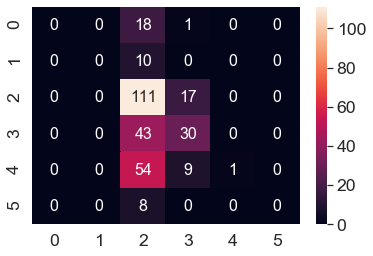

In [92]:
sn.set(font_scale=1.6)
sn.heatmap(confusion_matrix(y_test, predtraintfidf), annot=True,annot_kws={"size": 16}, fmt='g')# font size
plt.show()

In [93]:
dectree = DecisionTreeClassifier()
dectree.fit(X_train, y_train)
predtraintfidf = dectree.predict(X_test)
print('The accuracy using TF-IDF with Decision Tree Classifier is:', accuracy_score(y_test, predtraintfidf)*100)

The accuracy using TF-IDF with Decision Tree Classifier is: 52.980132450331126


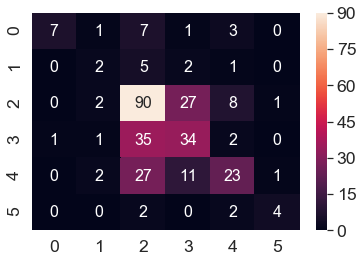

In [94]:
sn.set(font_scale=1.6)
sn.heatmap(confusion_matrix(y_test, predtraintfidf), annot=True,annot_kws={"size": 16}, fmt='g')# font size
plt.show()

In [95]:
lgtreg = LogisticRegression()
lgtreg.fit(X_train, y_train)
predtraintfidf = lgtreg.predict(X_test)
print('The accuracy using TF-IDF with Logistic Regression is:', accuracy_score(y_test, predtraintfidf)*100)

The accuracy using TF-IDF with Logistic Regression is: 50.331125827814574


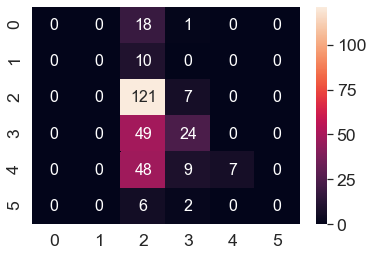

In [96]:
sn.set(font_scale=1.6)
sn.heatmap(confusion_matrix(y_test, predtraintfidf), annot=True,annot_kws={"size": 16}, fmt='g')# font size
plt.show()